### Installing Qiskit

In [74]:
%pip install qiskit[visualization] qiskit-ibm-runtime qiskit qiskit_aer qiskit_aer-gpu python-dotenv

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


### Libraries Importing


In [78]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer, AerSimulator
from qiskit.circuit import Parameter
from dotenv import load_dotenv
from sympy import *
import json, time, os

load_dotenv()
simulation_time = time.time() # to calculate simulation time
init_printing()


In [80]:
backend = AerSimulator(method="statevector")
print(backend.available_devices())
backend.set_options(device="GPU")

('CPU', 'GPU')


In [81]:
services = []

for i in range(1,2):
    services.append(QiskitRuntimeService(channel="ibm_quantum", token=os.getenv(f"TOKEN{i}"))) 

# backend = service.backend("ibm_osaka") # for real quantum
# backend = service.backend("ibm_kyoto") # for real quantum


In [85]:
services[0].least_busy()

<IBMBackend('ibm_brisbane')>


### Problem Definition

In [77]:
conf = json.load(open("conf_v2.json","r"))

''

In [61]:
G = conf["G"] # Number of Groups
H = conf["H"] # Number of hours in week
K = conf["K"] 

random_seed = conf["random_seed"]
shots = conf["shots"] 
layers = conf["layers"]

required_qubits = (G * H) + H
iterations = 0

print("Requried Qubits: ", required_qubits)

Requried Qubits:  6


In [62]:
equations = []

### Formulation

#### Equations

In [63]:
for i in range(1, G + 1):
  temp = total = 0
  for h in range(1, H + 1):
      temp += symbols(f"x_{i}{h}")
  total += (temp - 1)**2
  equations.append(total.expand())
equations

In [64]:
for h in range(1, H + 1):
  temp = total = 0
  for i in range(1, G + 1):
      temp += symbols(f"x_{i}{h}")
  total += (temp + symbols(f"τ_{h}") - 1)**2
  equations.append(total.expand())
equations

#### Decodeing Equations

In [65]:
def args(equation):
  return Add.make_args(equation)

def prepare_equation(term):
  theta = 1
  terms = []
  if type(term) == Mul:
    for i in term.args:
      if i.is_Integer:
        theta = i
      else:
        terms.append(i)
  else:
    terms.append(term.args[0]) 

  return [theta, decode(terms)]

def decode(terms):
  output = []
  for term in terms:

    term = str(term)

    if term.startswith("τ"):
      h = int(term[2])
      output.append((G * H + (h - 1)))

    elif term.startswith("x"):
      i = int(term[2])
      h = int(term[3])
      output.append((i - 1) * H + (h - 1))


  return output


In [66]:
prepared_equations = []
for equation in equations:
  temp = []
  for term in args(equation):
    if len(term.args) != 0:
      temp.append(prepare_equation(term))
  prepared_equations.append(temp)

prepared_equations

### Implementation

#### Objective Function

In [68]:
def objective(bit_string):
  bit_string = bit_string[::-1] # since qiskit represent solution in least significant bit format 
  cost = 0
  a = b = 0
  
  # equation a
  for i in range(1, G + 1):
    temp = 0
    for h in range(1, H + 1):
      temp += int(bit_string[(i - 1) * H + (h - 1)] )
    cost += (temp - 1)**2
    a += (temp - 1)**2
    

  # equation b
  for h in range(1, H + 1):
    temp = 0
    for i in range(1, G + 1):
      temp += int(bit_string[(i - 1) * H + (h - 1)])

    cost += (temp + int(bit_string[(G * H + (h - 1))]) - 1)**2
    # cost *= K
    b += (temp + int(bit_string[(G * H + (h - 1))]) - 1)**2 
    # b *= K

  return [cost, a, b]

#### Circuit

In [69]:
# qc = QuantumCircuit(required_qubits)

# for i in range(required_qubits):
#     qc.h(i)

# for equation in prepared_equations:
#   for term in equation:
#     theta = int(term[0])
#     locations = term[1]
#     if len(locations) == 1: # i.e. trivial term
#         qc.rz(theta , locations[0])
#     elif len(locations) == 2:
#         qc.rz(theta , locations[0]) # -1/4 * z1 = -1/4 * z1
#         qc.rz(theta , locations[1]) # -1/4 * z2 = -1/4 * z2
#         qc.rzz(theta , locations[0], locations[1]) # -1/4 * -z1z2 = 1/4 * z1z2

# for qubit in range(required_qubits - 1):
#     qc.rx(2  , qubit)

# qc.draw("mpl")

In [70]:
def layers_gen(p, initial_value = 1.0):
  return [initial_value] * p * 2

def create_qaoa_circ(thetas):
    n_layers = len(thetas)//2

    alpha = thetas[n_layers:]
    gamma = thetas[:n_layers]

    qc = QuantumCircuit(required_qubits)

    for i in range(required_qubits): 
      qc.h(i)

    for layer_index in range(n_layers):
        for equation in prepared_equations:
          for term in equation:
            theta = int(term[0])
            locations = term[1]
            
            if len(locations) == 1: # i.e. trivial term
                qc.rz(theta * 0.5 * alpha[layer_index], locations[0])

            elif len(locations) == 2:
                qc.rz(theta * -0.25 * alpha[layer_index], locations[0]) # -1/4 * z1 = -1/4 * z1
                qc.rz(theta * -0.25 * alpha[layer_index], locations[1]) # -1/4 * z2 = -1/4 * z2
                qc.rzz(theta * 0.25 * alpha[layer_index], locations[0], locations[1]) # -1/4 * -z1z2 = 1/4 * z1z2

        for qubit in range(required_qubits - 1):
            qc.rx(2 * gamma[layer_index] , qubit)

    qc.measure_all()
    print(thetas)

    return qc

In [71]:
total = [0] * 2
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj,a,b = objective(bit_string)
        total[0] += a
        total[1] += b
        avg += obj * count
        sum_count += count
    return avg/sum_count

def get_expectation():

    def execute_circ(theta):
        global iterations
        qc = create_qaoa_circ(theta)
        tc = transpile(qc,backend,optimization_level=3,seed_transpiler=random_seed)
        
        counts = backend.run(tc, seed_simulator=random_seed, shots=shots).result().get_counts()
        print(compute_expectation(counts))
        iterations += 1
        return compute_expectation(counts)

    return execute_circ

In [72]:
from scipy.optimize import minimize,differential_evolution
expectation = get_expectation()
start_time = time.time()
res = minimize(expectation, layers_gen(layers), method='COBYLA') 
minimization_time = time.time() - start_time

res

RuntimeError: No CUDA device available!

In [ ]:
print("a:",total[0])
print("b:",total[1])


a: 288554066
b: 652851802


### Results

50868
Solution 011100000000011100000000 cost: 12 count 4
Solution 001101000100001101000100 cost: 13 count 4
Solution 010000110011110000110011 cost: 24 count 3
Solution 010110101010101010101010 cost: 37 count 3
Solution 101001010000010101010101 cost: 23 count 3
Solution 011100000000000000000000 cost: 6 count 3
Solution 111111111111111111111101 cost: 131 count 3
Solution 011101111010110111011010 cost: 50 count 3
Solution 000010100101010101010101 cost: 23 count 3
Solution 011011011101110111010010 cost: 51 count 3


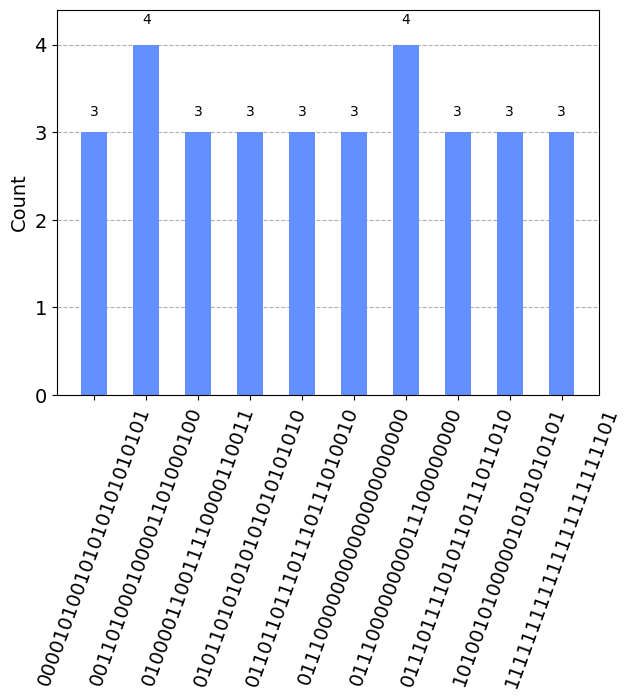

In [ ]:
from qiskit.visualization import plot_histogram

qc_res = create_qaoa_circ(res.x)
counts = backend.run(qc_res, seed_simulator=random_seed, shots=shots).result().get_counts()


counts = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))
counts_cost = dict(sorted(counts.items(), key=lambda item: item[1],reverse=True))

values = list(counts.values())
binary = list(counts.keys())

output = {}

print(len(counts))

for key in binary:
  if objective(key)[0] == 0:
    print("-----------------")
    print("BINGO")
    print(key)
    print(counts[key])
    print("-----------------")

for key in binary[:10]:
    print("Solution",key ,"cost:",objective(key)[0],"count", counts[key])
    output[key] = counts[key]

# plot_histogram(output).savefig(f"./png/{H}_{M}_{N}_{shots}_{layers}_{time.time_ns()}.png")
plot_histogram(output)

In [ ]:
sol = required_qubits
sol_bin = ""

for i in counts:
  ob = objective(i)[0]
  if ob < sol:
    sol = ob
    sol_bin = i

counts["H"] = H
counts["G"] = G
counts["K"] = K
counts["shots"] = shots
counts["layers"] = layers
counts["solution"] = sol_bin
counts["solution_cost"] = sol
counts["solution_count"] = counts[sol_bin]
counts["minimization_time"] = minimization_time
counts["execution_time"] = time.time() - simulation_time
counts["iterations"] = iterations 

print("Solution",sol_bin ,"cost:",sol,"count", counts[sol_bin])

Solution 000001001000100000100001 cost: 1 count 1


In [ ]:
file = open(f"./json/{H}_{G}_{K}_{shots}_{layers}_{time.time_ns()}.json", "w")
file.write(json.dumps(counts))
file.flush()

In [ ]:
counts["execution_time"]

In [ ]:
minimization_time